### Model assessment
Here we compared the weights learned by several model iterations, to highlight
- Performance user parameter combinations
- Interpretation based on TF regulators
- Coherence or learned graph-weights when assisting RNA-weights, or only using ATAC-weights

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ~/workspace/theislab/mubind/docs/notebooks/single_cell

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/miniconda3/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
!readlink -f .

/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell


In [4]:
import torch
import mubind as mb
import scanpy as sc

In [5]:
!ls -ltrh /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus*

-rw-rw-r-- 1 ilibarra ilibarra 7.1M Jun 13 02:40 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_use_logdynamic_0_obs2930.pth
-rw-rw-r-- 1 ilibarra ilibarra 8.8M Jun 13 02:40 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_use_logdynamic_1_obs2930.pth
-rw-rw-r-- 1 ilibarra ilibarra 682M Jun 13 02:40 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_sample_train_obs2930.h5ad
-rw-rw-r-- 1 ilibarra ilibarra  45M Jun 13 02:40 /home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell/dentategyrus_train_dataloader_obs2930.pkl


In [6]:
# query
obs_id = 2930


# load models
model_by_logdynamic = {}
for use_logdynamic in [False, True]:
    p = 'dentategyrus_use_logdynamic_%i_obs%s.pth' % (use_logdynamic, obs_id)
    print(p)
    model_by_logdynamic[use_logdynamic] = torch.load(p)

dentategyrus_use_logdynamic_0_obs2930.pth
dentategyrus_use_logdynamic_1_obs2930.pth


In [7]:
ad = sc.read_h5ad('dentategyrus_sample_train_obs%s.h5ad' % obs_id)
# ad = sc.read_h5ad('atac_train.h5ad')
#rna_sample = sc.read_h5ad('rna_sample_train.h5ad')
rna_sample = ad

In [8]:
rna_sample.shape

(2930, 13187)

In [9]:
import pickle
train = pickle.load(open('dentategyrus_train_dataloader_obs%s.pkl' % obs_id, 'rb'))

In [10]:
%load_ext line_profiler

In [11]:
# # load the pancreas multiome dataset
# rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')


In [12]:
# %lprun -f model.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [13]:
# %lprun -f model.binding_modes.forward model.optimize_iterative(train, n_epochs=10, skip_kernels=list([0]) + list(range(2, 500)), opt_kernel_shift=[0, 0] + [0] * (n_kernels), opt_kernel_length=[0, 0] + [0] * (n_kernels))

In [14]:
import matplotlib.pyplot as plt

False
True
3
order None
0 out of 288...
break


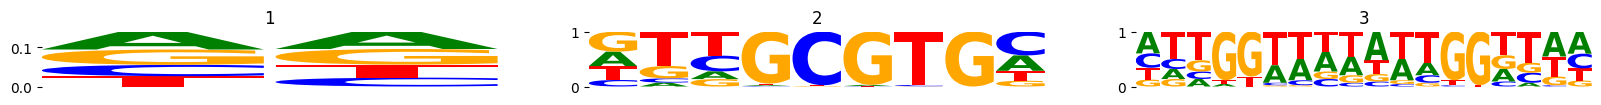

True
True
3
order None
0 out of 288...
break


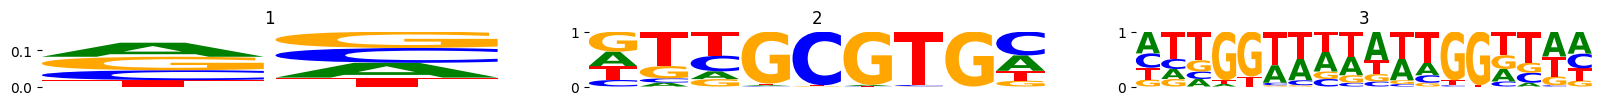

In [15]:

for optimize_log_dynamic in model_by_logdynamic:
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 20, 5
    rcParams['figure.dpi'] = 100
    mb.pl.logo(model, n_cols=3, show=True, n_rows=6, stop_at=4) #  log=True)
    plt.show()


True


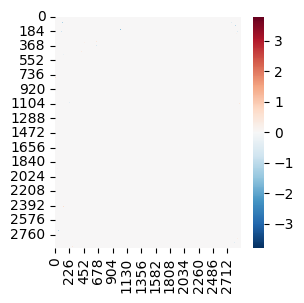

In [16]:
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic]
    print(optimize_log_dynamic)

    tsum = torch.sum
    texp = torch.exp
    tspa = torch.sparse_coo_tensor
    tsmm = torch.sparse.mm
    t = torch.transpose

    # connectivities
    C = model.graph_module.conn_sparse
    a_ind = C.indices()

    log_dynamic = model.graph_module.log_dynamic
    D = model.graph_module.log_dynamic
    D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
    D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
    D = D_tril + t(D_triu, 0, 1)
    # log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
    # triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
    D

    import seaborn as sns
    mb.pl.set_rcParams({'figure.figsize': [3, 3]})
    sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')
    plt.show()

In [17]:
model = model_by_logdynamic[1]

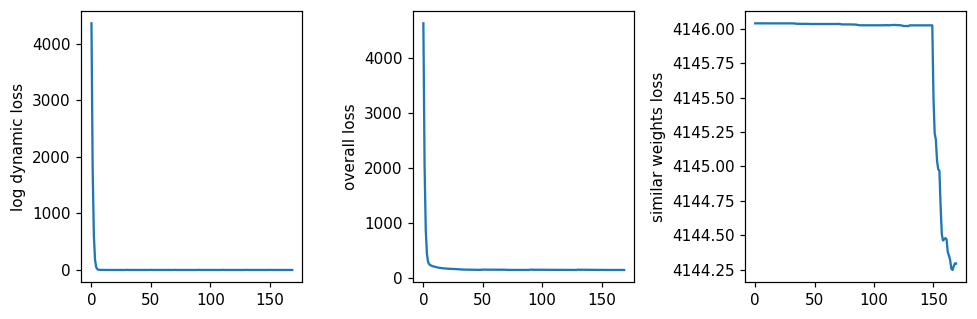

In [18]:
mb.pl.set_rcParams({'figure.figsize': [12, 3], 'figure.dpi': 110})
plt.subplot(1, 4, 1)
plt.plot(model.loss_history_log_dynamic)
plt.ylabel('log dynamic loss')
plt.subplot(1, 4, 2)
plt.plot(model.loss_history)
plt.ylabel('overall loss')
plt.subplot(1, 4, 3)
plt.plot(model.loss_history_sym_weights)
plt.ylabel('similar weights loss')
plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np

False
True


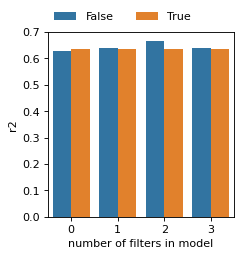

In [20]:
rcParams['figure.figsize'] = 3, 5
r2_all = []
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    # contributions per newly added kernel
    import seaborn as sns
    if len(model.best_r2_by_new_filter) != 0:
        r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
        r2['opt_log_dynamic'] = optimize_log_dynamic
        r2_all.append(r2)

if len(r2_all) > 0:
    r2_all = pd.concat(r2_all)
    rcParams['figure.figsize'] = 3, 3
    rcParams['figure.dpi'] = 80
    ax = sns.barplot(data=r2_all, x='index', y='r2', hue='opt_log_dynamic', )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.4, 1), ncol=3, title=None, frameon=False)

    plt.xlabel('number of filters in model')
    plt.show()

In [21]:

model = model_by_logdynamic[True]

torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
ad.obs['dynamic_score'] = dynamic_score

ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2


In [22]:
ad.obs['dynamic_score'].describe()

count    2930.000000
mean        0.454369
std         0.056227
min         0.000000
25%         0.451436
50%         0.454367
75%         0.454485
max         1.000000
Name: dynamic_score, dtype: float64

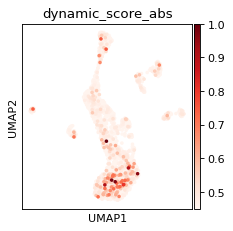

In [23]:
ad.obs['dynamic_score_abs'] = ad.obs['dynamic_score'].abs()
sc.pl.umap(ad, color='dynamic_score_abs', color_map='Reds', vmin=.45)

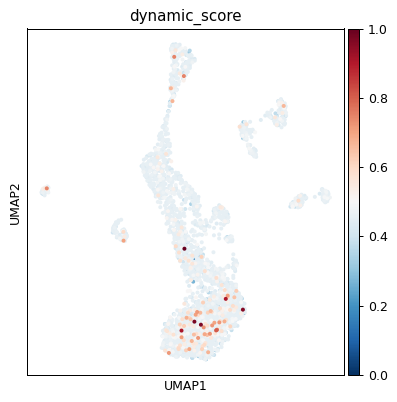

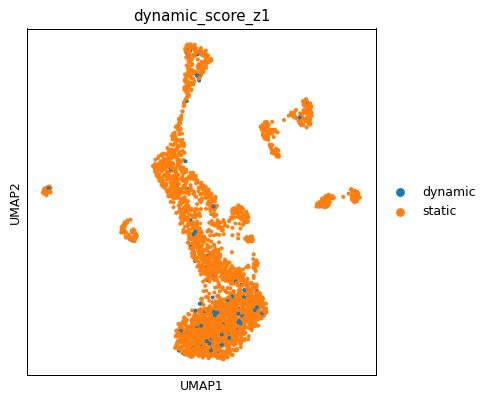

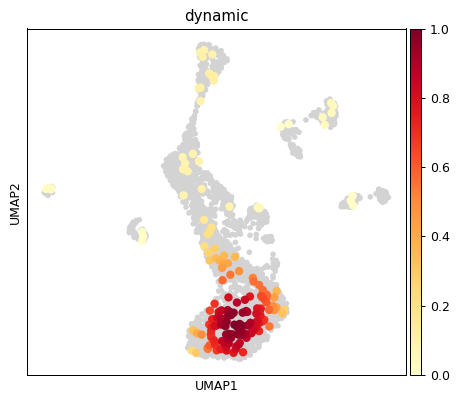

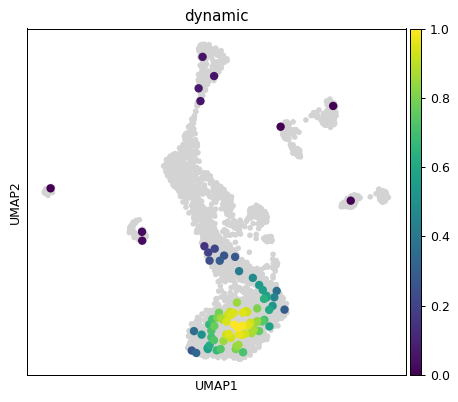

In [24]:


# contributions per newly added kernel
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)

sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic', color_map='viridis') # basis='umap', groupby='dynamic_score_cluster')

<Axes: >

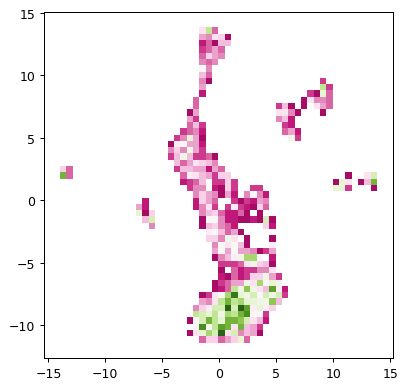

In [25]:
import seaborn as sns
umap = ad.obsm['X_umap']
sns.histplot(x=umap[:, 0], y=umap[:, 1], bins=50, cmap='PiYG')

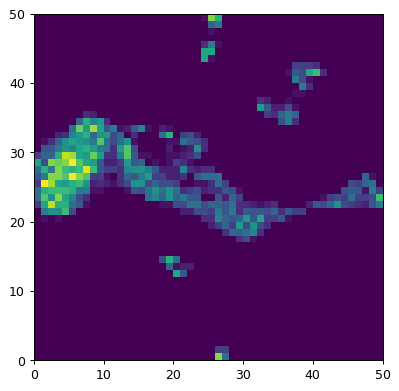

In [26]:
plt.pcolormesh(
    np.histogram2d(umap[:, 0], umap[:, 1], bins=50)[0]
)

In [27]:
x, y = np.meshgrid(umap[:, 0], umap[:, 1])

In [28]:
x = umap[:,1] # array_txt[:,0]
y = umap[:,1] # array_txt[:,1]
z = ad.obs['dynamic_score'].values # array_txt[:,2]


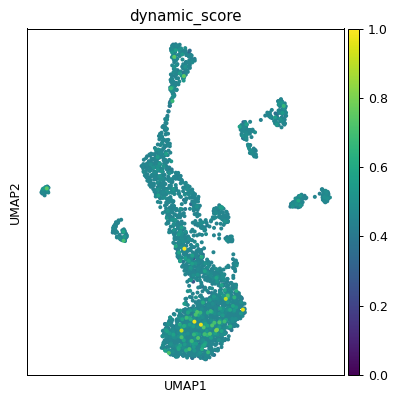

In [29]:
sc.pl.umap(ad, color='dynamic_score')

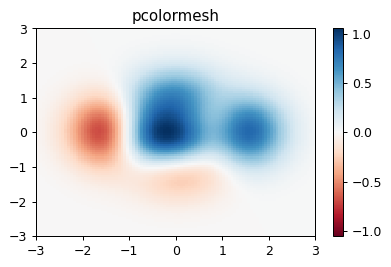

In [30]:
import matplotlib.pyplot as plt
import numpy as np
rcParams['figure.figsize'] = 5, 3

# generate 2 2d grids for the x & y bounds
y, x = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = (1 - x / 2. + x ** 5 + y ** 3) * np.exp(-x ** 2 - y ** 2)
z = z[:-1, :-1]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [31]:
import itertools
import numpy as np

def grid(x, y, z, size_x=1, size_y=1):

    def pairwise(iterable):
        "s -> (s0,s1), (s1,s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)

    minx, maxx = int(min(x)), int(max(x)) + 1
    miny, maxy = int(min(y)), int(max(y)) + 1

    result = []
    x_edges = pairwise(np.arange(minx, maxx + 1, size_x))
    for xleft, xright in x_edges:
        xmask = np.logical_and(x >= xleft, x < xright)
        y_edges = pairwise(np.arange(miny, maxy + 1, size_y))
        for yleft, yright in y_edges:
            ymask = np.logical_and(y >= yleft, y < yright)
            cell = z[np.logical_and(xmask, ymask)]
            result.append(cell.sum())

    result = np.array(result).reshape((maxx - minx, maxy - miny))
    return np.flip(result.T, 0)


In [32]:
cell_type_key = 'clusters'

In [33]:
grid_dyn_score = grid(umap[:,0], umap[:,1], ad.obs['dynamic_score'], size_x=1, size_y=1)
grid_counts = grid(umap[:,0], umap[:,1], ad.obs[cell_type_key].cat.codes.values, size_x=1, size_y=1)

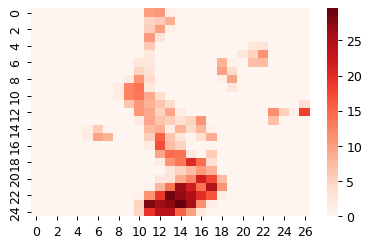

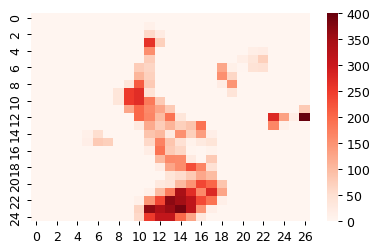

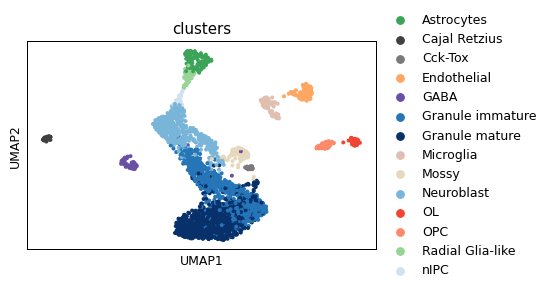

In [34]:

sns.heatmap(grid_dyn_score, cmap='Reds')
plt.show()
sns.heatmap(grid_counts, cmap='Reds')
plt.show()

sc.pl.umap(ad, color=cell_type_key)

In [35]:
# for optimize_log_dynamic in model_by_logdynamic:
#     mb.pl.set_rcParams({'figure.figsize': [3, 3], 'figure.dpi': 90})
#     print(optimize_log_dynamic)
#     model = model_by_logdynamic[optimize_log_dynamic]
#     mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)
#     plt.show()

#     mb.pl.set_rcParams({'figure.figsize': [10, 7], 'figure.dpi': 90})
#     mb.pl.logo(model,
#                title=False,
#                xticks=False,
#                rowspan_dinuc=0,
#                rowspan_mono=1,
#                n_rows=12,
#                n_cols=3,
#                stop_at=20) # n_cols=len(reduced_groups))
#     plt.show()


In [36]:
model = model_by_logdynamic[True]

In [37]:
G = model.graph_module.conn_sparse.detach().cpu().to_dense() # (C, C)

In [38]:
# number of non_zero weights
len(G[G != 0])

62308

In [39]:
# output = model(**inputs, use_conn=False, return_binding_scores=True)

In [40]:
print('here...')

here...


In [41]:
ad

AnnData object with n_obs × n_vars = 2930 × 13187
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
    var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
    uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distance

In [42]:
model = model.cuda()

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
# device

In [44]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [45]:
train

In [46]:
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    if not optimize_log_dynamic:
        continue
    model = model_by_logdynamic[optimize_log_dynamic].cuda()

    umap = ad.obsm['X_umap'].copy()
    umap = np.sort(umap, 0)

    x = umap[:,0]
    y = umap[:,1]
    X, Y = np.meshgrid(x, y)

    n_points = x.shape[0]
    # x-component to the right
    u = np.ones((n_points, n_points))
    # y-component zero
    v = np.zeros((n_points, n_points))

    pred = []
    for i, batch in enumerate(train):
        # Get a batch and potentially send it to GPU memory.
        mononuc = batch["mononuc"].to(device)
        # print(i, mononuc.shape)
        b = batch["batch"].to(device) if "batch" in batch else None
        rounds = batch["rounds"].to(device) if "rounds" in batch else None
        countsum = batch["countsum"].to(device) if "countsum" in batch else None
        seq = batch["seq"] if "seq" in batch else None
        residues = batch["residues"].to(device) if "residues" in batch else None
        if residues is not None and train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                      "residues": residues}
        elif residues is not None:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
        elif train.dataset.store_rev:
            mononuc_rev = batch["mononuc_rev"].to(device)
            inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
        else:
            inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

        inputs['scale_countsum'] = model.datatype == 'selex'

        
        output = model(**inputs, use_conn=False, return_binding_scores=True)

        output = output.cpu().detach().numpy()
        print('here...')
        print(output.shape)

        print(output.sum())
        pred.append(output)

    # pred = np.concatenate(pred).T

    binding_scores = np.concatenate(pred).T


    # ad.layers['velocity'] = pred
    
    # conn = model.graph_module.conn_sparse.detach().cpu()
    # conn = model.graph_module.conn_sparse.detach().cpu().to_dense()
    # v = conn.sum(axis=1)
    # ad.layers['velocity'] = torch.stack([v,] * ad.shape[1], axis=1).numpy()
    
    # ad.layers['counts'] = ad.X

    # mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 90})
    # plt.hist(model.graph_module.conn_sparse.values().detach().cpu().numpy())
    # plt.show()

    # import scvelo as scv

    # sc.pp.neighbors(ad)

    # # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # # ad.layers['velocity'] = ad.obs['dynamic_score']
    
    # scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
    # ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)


X = ad.X.A
G @ binding_scores
np.random.shuffle(binding_scores)

False
True
here...
(256, 2930)
3888985000000.0
here...
(256, 2930)
6156587000000.0
here...
(256, 2930)
4325545300000.0
here...
(256, 2930)
6200477400000.0
here...
(256, 2930)
3039824000000.0
here...
(256, 2930)
4329308000000.0
here...
(256, 2930)
3846854000000.0
here...
(256, 2930)
5839586300000.0
here...
(256, 2930)
6402586700000.0
here...
(256, 2930)
4577684000000.0
here...
(256, 2930)
6640944300000.0
here...
(114, 2930)
1969247900000.0


In [47]:
import scvelo as scv

In [48]:
ad.shape, binding_scores.shape

((2930, 13187), (2930, 2930))

In [49]:
binding_scores

array([[5695416. , 4729683.5, 4508358.5, ..., 5710716.5, 5913374. ,
        5358967.5],
       [5707284. , 4737181.5, 4515254.5, ..., 5708774. , 5912796.5,
        5356831.5],
       [5709430.5, 4745401.5, 4523603.5, ..., 5709722. , 5915232.5,
        5356727. ],
       ...,
       [5742742.5, 4766820.5, 4543332.5, ..., 5719827. , 5926192.5,
        5365891.5],
       [5735228.5, 4769770. , 4546883. , ..., 5719728.5, 5926823. ,
        5364963. ],
       [5717134. , 4752938. , 4530839.5, ..., 5719859. , 5921852.5,
        5367111. ]], dtype=float32)

In [50]:
# ad
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

In [51]:
np.random.shuffle(binding_scores)
binding_scores

array([[5672059. , 4715783.5, 4495781.5, ..., 5717793. , 5916743. ,
        5366537. ],
       [5672731. , 4710519.5, 4489996. , ..., 5702026. , 5899734. ,
        5351897. ],
       [5714022.5, 4737715.5, 4515371.5, ..., 5711495. , 5916028.5,
        5359233.5],
       ...,
       [5707484.5, 4735757.5, 4513556.5, ..., 5704747.5, 5910405. ,
        5353114.5],
       [5762422. , 4780258.5, 4555688.5, ..., 5722983. , 5931150. ,
        5368327.5],
       [5720347.5, 4741201.5, 4518577.5, ..., 5709697.5, 5915178. ,
        5357563.5]], dtype=float32)

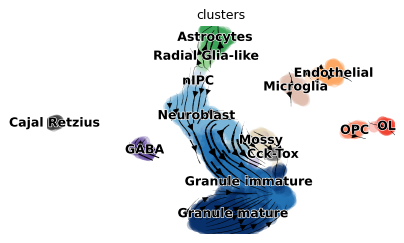

In [52]:
try:
    scv.pl.velocity_embedding_stream(rna_sample, color=cell_type_key)
except Exception:
    print("sample too small.")

In [53]:
# np.random.shuffle(binding_scores)
# ad.layers['velocity'] = binding_scores
# scv.tl.velocity_graph(ad, vkey='velocity', xkey='counts')
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', show=False) #  X_grid='X_umap', V=V)

<Axes: >

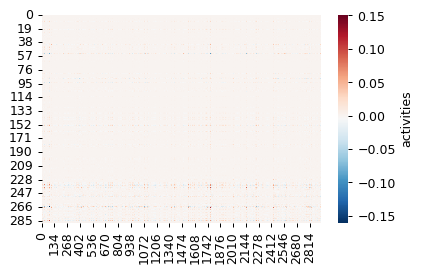

In [54]:
import seaborn as sns
act = model.get_log_activities().detach().cpu().squeeze(0)
sns.heatmap(act, cmap='RdBu_r', cbar_kws={'label': 'activities'})

In [163]:
anno[anno['Name'] == 'NR/20']

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size,Name_unique
145,248,NR/20,nuclearreceptor,ANDR_MOUSE.H11MO.0.A,17,2,16,13,NR/20


In [164]:
clu[clu['Cluster_ID'] == 248]

,Cluster_ID,Motif,Database,Consensus,Relative_orientation,Width,Left_offset,Right_offset
1998,248,ANDR_MOUSE.H11MO.0.A,HOCOMOCO_v11,GGAACACTCTGTTCCT,+,16,1,0
1999,248,GCR_MOUSE.H11MO.0.A,HOCOMOCO_v11,AGAACATTCTGTTCT,-,15,1,1
2000,248,PRGR_MOUSE.H11MO.0.A,HOCOMOCO_v11,AGAACATTCTGTTCT,-,15,1,1
2001,248,PRGR_HUMAN.H11MO.0.A,HOCOMOCO_v11,AGAACATTCTGTTCTT,+,16,1,0
2002,248,GCR_HUMAN.H11MO.0.A,HOCOMOCO_v11,AGAACATTCTGTTCT,-,15,1,1
2003,248,Ar_MA0007.3,Jaspar2018,GGGTACACCGTGTTCCC,-,17,0,0
2004,248,NR3C2_MA0727.1,Jaspar2018,GGGAACATTGTGTTCCC,-,17,0,0
2005,248,NR3C1_MA0113.3,Jaspar2018,GGGAACATTATGTACCC,-,17,0,0
2006,248,AR_nuclearreceptor_2,Taipale_Cell_2013,GGGTACACCGTGTTCCC,-,17,0,0
2007,248,NR3C2_nuclearreceptor_1,Taipale_Cell_2013,GGGAACATTGTGTTCCC,-,17,0,0


tensor([ 41, 255, 282, 180,  88, 153, 251,  53,  93, 235, 267, 236, 239, 285,
        265])


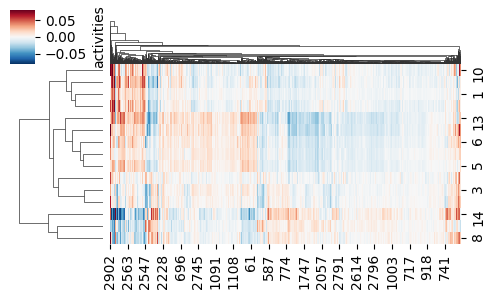

In [55]:
# highlight the top-n filters per cell, with the top variability
rcParams['figure.dpi'] = 100
n_show = 15
print(act.var(axis=1).sort()[1][-n_show:])
act_sel = act[act.var(axis=1).sort()[1][-n_show:],:]
vmax = act_sel.abs().max()
sns.clustermap(act_sel,
               vmin=-vmax / 2, vmax=vmax / 2,
               cmap='RdBu_r',
               
               cbar_kws={'label': 'activities'},
               figsize=[5, 3])


In [56]:
rna_sample.layers['velocity'].shape, rna_sample.shape

((2930, 13187), (2930, 13187))

In [57]:
# scv.pl.velocity_graph(rna_sample)

In [58]:

# ax = scv.pl.velocity_embedding_stream(ad,
#                                       color='celltype',
#                                       # density=2,
#                                       arrow_color='black',
#                                       n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [59]:
# ax = scv.pl.velocity_embedding_stream(ad, color='celltype', density=2, arrow_color='black', n_neighbors=15) # show=False) #  X_grid='X_umap', V=V)

In [60]:
# scv.pl.velocity_embedding_stream(ad, color='celltype', n_neighbors=15) #  X_grid='X_umap', V=V)

## Study the asssociations betweeen obtained weights and cluster-specific transcription factors

Load information from archetypes DB (Vierstra et al 2020)

In [61]:
rna_sample, ad.shape

(AnnData object with n_obs × n_vars = 2930 × 13187
     obs: 'clusters', 'age(days)', 'clusters_enlarged', 'n_counts', 'velocity_self_transition', 'dynamic_score', 'dynamic_score_cluster', 'dynamic_score_z1', 'dynamic_score_z2', 'dynamic_score_abs', 'umap_density_dynamic_score_z1', 'umap_density_dynamic_score_z2'
     var: 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'chrom', 'pos', 'strand', 'tss_start', 'tss_end', 'chromosome_name', 'k', 'acc_score', 'acc_score_rank', 'chr', 'summit.start', 'summit.end', 'k.summit'
     uns: 'clusters_colors', 'clusters_enlarged_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'dynamic_score_z1_colors', 'umap_density_dynamic_score_z1_params', 'umap_density_dynamic_score_z2_params'
     obsm: 'X_pca', 'X_umap', 'velocity_umap'
     varm: 'PCs'
     layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
     obsp: 'connectivities', '

In [62]:
rna_sel = rna_sample # rna[rna.obs_names.isin(ad.obs_names),:].copy()
rna_sel.shape

(2930, 13187)

In [63]:
pwd

'/home/ilibarra/workspace/theislab/mubind/docs/notebooks/single_cell'

In [64]:
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'

anno = mb.datasets.archetypes_anno()

In [65]:
rna_sel.shape
anno.sort_values('Cluster_ID')

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size
61,1,HD/1,homeodomain,LHX6_homeodomain_3,12,0,12,2
72,2,HD/2,homeodomain,ALX3_MA0634.1,26,8,16,186
79,3,HD/3,homeodomain,VENTX_homeodomain_2,21,3,20,1
80,4,HD/4,homeodomain,BARX1_MOUSE.H11MO.0.C,17,5,13,17
81,5,HD/5,homeodomain,BARX1_homeodomain_1,21,2,18,6
...,...,...,...,...,...,...,...,...
163,282,PAX/2,PAX,PAX5_HUMAN.H11MO.0.A,24,4,21,3
161,283,PAX-halfsite,PAX,Pax2_MA0067.1,8,1,7,1
0,284,AHR,bHLH,AHR_HUMAN.H11MO.0.B,9,2,8,3
105,285,KLF/SP/3,C2H2,KLF8_HUMAN.H11MO.0.C,9,0,9,2


In [66]:
ad.obs

,clusters,age(days),clusters_enlarged,n_counts,velocity_self_transition,dynamic_score,dynamic_score_cluster,dynamic_score_z1,dynamic_score_z2,dynamic_score_abs,umap_density_dynamic_score_z1,umap_density_dynamic_score_z2
index,,,,,,,,,,,,
AAACATACCCATGA,Granule immature,35,Granule-immature,2460.500000,0.051353,0.326941,static,static,static,0.326941,0.885660,0.880093
AAACATACCGTAGT,Radial Glia-like,12,Radial Glia-like,2460.499756,0.220968,0.664861,dynamic,dynamic,dynamic,0.664861,0.098424,0.062891
AAACATACGAGAGC,Granule mature,35,Granule-mature,2460.499756,0.069691,0.423477,static,static,static,0.423477,0.498209,0.497915
AAACATACTGAGGG,Granule immature,12,Granule-immature,2460.500000,0.080728,0.509396,dynamic,static,static,0.509396,0.309090,0.301410
AAACATTGGCATCA,Granule immature,35,Granule-immature,2460.500000,0.119560,0.184905,static,static,static,0.184905,0.901531,0.897236
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCTACTTCCCGT,Granule immature,35,Granule-immature,2460.500000,0.034482,0.451430,static,static,static,0.451430,0.379815,0.369171
TTTGACTGCCTGTC,Neuroblast,12,Neuroblast 2,2460.499756,0.131426,0.448702,static,static,static,0.448702,0.281247,0.272061
TTTGACTGTCTGGA,Granule mature,35,Granule-mature,2460.499756,0.100035,0.426829,static,static,static,0.426829,0.752995,0.754203


False


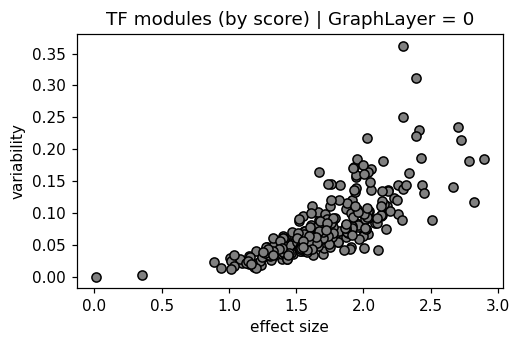

True


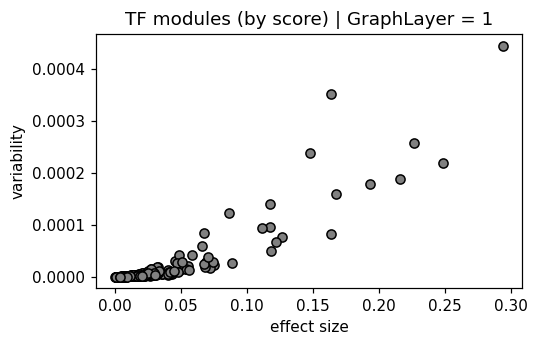

In [67]:


for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    # log_act.columns = ['intercept', 'dinuc_bias'] + list(anno['Seed_motif'].values)
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 110})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var, color='gray', edgecolors='black')
    plt.xlabel('effect size')
    plt.ylabel('variability')
    plt.title('TF modules (by score) | GraphLayer = %i' % optimize_log_dynamic )
    plt.show()

In [68]:
# unique names for annotation
names = anno['Name'] # .sort_values('Name')
added = dict()
new_name = []
for name in names:
    if not name in added:
        new_name.append(name)
        added[name] = 0
    else:
        new_name.append(name + '_%i' % added[name])
        added[name] += 1
anno['Name_unique'] = new_name


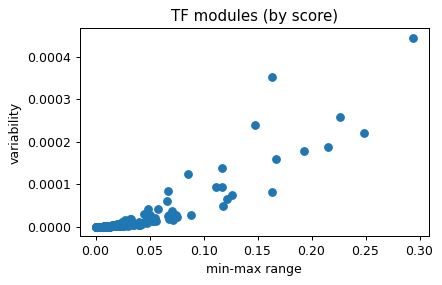

In [69]:
from scipy.stats import spearmanr
res = []
for optimize_log_dynamic in model_by_logdynamic:
    if not optimize_log_dynamic:
        continue

    model = model_by_logdynamic[optimize_log_dynamic]
    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    # log_act.columns = anno['Seed_motif'][2]
    log_act.columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))
    log_act.index = ad.obs_names
    ad.obsm['mubind_activities'] = log_act

    mb.pl.set_rcParams({'figure.figsize': [5, 3], 'figure.dpi': 90})
    delta = (log_act.max(axis=0) - log_act.min(axis=0))
    var = log_act.var(axis=0)
    plt.scatter(delta, var)
    plt.xlabel('min-max range')
    plt.ylabel('variability')
    plt.title('TF modules (by score)')
    plt.show()

    for c in log_act:
        a = log_act[c]
        b = ad.obs['dynamic_score'].values
        # print(a.shape, b.shape)
        res.append([optimize_log_dynamic, c] + list(spearmanr(a, b)))

res = pd.DataFrame(res, columns=['opt_log_dynamic', 'archetype_id', 'spearman', 'p_val'])



In [70]:

# add archetypes name
meta = pd.DataFrame(pd.concat([delta, var], axis=1))
meta.columns = ['max_effect', 'variability']
meta['name'] = ['intercept', 'dinuc_bias'] + list(range(1, 287))
clu = mb.datasets.archetypes_clu()
meta['archetypes_name'] = meta['name'].map(anno.set_index('Cluster_ID')['Name_unique'])
meta['archetypes_name'] = np.where(pd.isnull(meta['archetypes_name']), meta['name'], meta['archetypes_name'])

meta['archetypes_seed'] = meta['name'].map(anno.set_index('Cluster_ID')['Seed_motif'])

meta['filter_position'] = range(0, meta.shape[0])

In [71]:
meta = meta.sort_values('max_effect', ascending=0)
meta

res = res.merge(meta, left_on='archetype_id', right_on='name')
res = res.sort_values('p_val', ascending=True)

In [72]:
name_by_filter_id = meta['archetypes_name'].to_dict()
# name_by_filter_id

## Observe general scores per case

<Axes: xlabel='max_effect', ylabel='archetypes_name'>

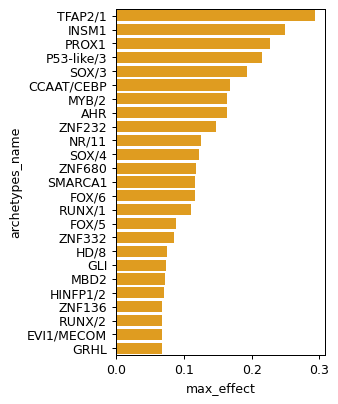

In [73]:
rcParams['figure.figsize'] =3, 5
sns.barplot(data=res.sort_values('max_effect', ascending=False).head(25), x='max_effect', y='archetypes_name', color='orange')

In [74]:
res

,opt_log_dynamic,archetype_id,spearman,p_val,max_effect,variability,name,archetypes_name,archetypes_seed,filter_position
123,True,122,-0.071296,0.000112,0.007311,1.179806e-07,122,FEZF1,FEZF1_HUMAN.H11MO.0.C,123
107,True,106,-0.070254,0.000141,0.002688,2.069622e-08,106,IRF/2,BC11A_HUMAN.H11MO.0.A,107
95,True,94,0.063638,0.000567,0.001577,1.317704e-08,94,SOX/5,SOX10_HMG_3,95
253,True,252,0.063046,0.000639,0.041371,8.169157e-06,252,MYB/5,MYBA_MOUSE.H11MO.0.C,253
247,True,246,0.062027,0.000781,0.011513,7.071298e-07,246,RFX/3,RFX5_HUMAN.H11MO.0.A,247
...,...,...,...,...,...,...,...,...,...,...
278,True,277,-0.000161,0.993062,0.026827,1.406599e-05,277,GMEB2/2,GMEB2_MA0862.1,278
215,True,214,-0.000109,0.995274,0.007433,3.693430e-07,214,DMRT3,DMRT3_MA0610.1,215
166,True,165,0.000108,0.995327,0.023036,2.257794e-06,165,RBPJ,RBPJ_MA1116.1,166
222,True,221,0.000078,0.996628,0.013644,2.299990e-06,221,ZNF53,ZNF354C_MA0130.1,222


True
1
order None
0 out of 288...
10 out of 288...
break


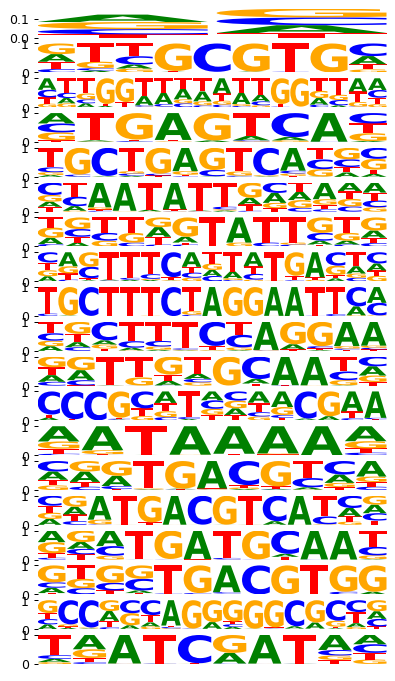

In [75]:
# visualize the logos as obtained by the model in each step
mb.pl.set_rcParams({'figure.figsize': [5, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40, n_cols=1, stop_at=20)
           # n_rows=len(res.head(20).index),

True
1
order Index([123, 107,  95, 253, 247, 156,   2,  91, 242, 211, 254, 117,  26, 100,
       187,  36, 204, 219, 231,  37],
      dtype='int64')
0 out of 288...
10 out of 288...


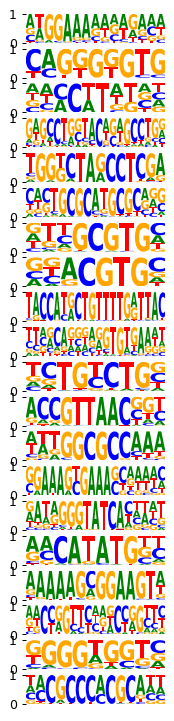

<Figure size 180x1800 with 0 Axes>

In [76]:
mb.pl.set_rcParams({'figure.figsize': [2, 20], 'figure.dpi': 90})
mb.pl.logo(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=40,
           # n_rows=len(res.head(20).index),
           n_cols=1, order=res.head(20).index) # n_cols=len(reduced_groups))
plt.tight_layout()
plt.show()

In [77]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 2.747772


In [78]:
# for k in ad.obsm['log_activities'].iloc[:,2:]:
#     ad.obs[str(k)] = ad.obsm['log_activities'][k]
# sc.pl.umap(ad, color=map(str, ad.obsm['log_activities'].iloc[:,2:]), cmap='Reds')


In [165]:
rna_sel.obsm['X_umap'] = ad.obsm['X_umap']

In [166]:
def find_varname(ad, k, shuffle=False):
    if not shuffle:
        return ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
    else:
        ad_sel = ad.var_names[ad.var_names.str.upper().str.startswith(k.upper())]
        return pd.Series(ad.var_names).sample(ad_sel.shape[0]).values

In [167]:
from scipy.stats import spearmanr, pearsonr

Calculate global correlations between the activities obtained per motif and gene-specific expression

In [168]:

all_targets = set()
for optimize_log_dynamic in model_by_logdynamic:
    print(optimize_log_dynamic)
    model = model_by_logdynamic[optimize_log_dynamic]

    log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act = pd.DataFrame(log_act.detach().cpu().numpy())
    log_act.index = ad.obs_names

    ad.obsm['log_activities'] = log_act
    ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

    # collect all targets
    for k in ad.obsm['log_activities'].iloc[:,2:]:
        log_act = ad.obsm['log_activities'][k].values
        names = set()
        clu_sel = clu[clu['Cluster_ID'] == k]['Motif']
        for g in clu_sel:
            names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
        for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
            names.add(g.split('_')[0].split('.')[0])
        # print(k, names)
        targets = set()
        for name in names:
            target = find_varname(rna_sel, name)
            for t in target:
                all_targets.add(t)
        if len(targets) > 0 and False:
            sc.pl.umap(rna_sel, color=targets, cmap='Reds')


False
True


In [246]:

def get_act_gene_corr(model_by_logdynamic,
                      shuffle=False,
                      random_state=0,
                      query_cluster_id=None):
    print('association between motif activities and related TF targets (shuffle = %i)' % shuffle)
    res = []
    # print(len(all_targets))

    rna_sel_df = rna_sel.to_df()

    for optimize_log_dynamic in model_by_logdynamic:
        print('use GraphLayer = %i' % optimize_log_dynamic)
        model = model_by_logdynamic[optimize_log_dynamic]

        log_act = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
        log_act = pd.DataFrame(log_act.detach().cpu().numpy())
        log_act.index = ad.obs_names

        ad.obsm['log_activities'] = log_act
        ad.obsm['log_activities'].columns = ['intercept', 'dinuc_bias'] + list(range(1, 287))

        if shuffle:
            random_cols = ad.obsm['log_activities'].iloc[:,2:].columns.values
            np.random.shuffle(random_cols)
            # random_cols
        
        for ki, k in enumerate(ad.obsm['log_activities'].iloc[:,2:]):
            next_log_act = ad.obsm['log_activities'][k].values

            # if shuffle:
            #     next_log_act = ad.obsm['log_activities'][random_cols[ki]].values
            
            # print(ki)
            # if ki % 30 == 0:
            #     print(ki)
            if query_cluster_id is not None and k != query_cluster_id:
                continue
            
            names = set()
            clu_sel = clu[clu['Cluster_ID'] == k]['Motif']

            for g in clu_sel:
                names.add(g.split('_')[0].split('.')[0].split('+')[0].upper())
            for g in anno[anno['Cluster_ID'] == k]['Seed_motif']:
                names.add(g.split('_')[0].split('.')[0])
            # print(k, names)
            next_targets = set()
            for name in names:
                if len(name) <= 2:
                    continue
                target = find_varname(rna_sel, name, shuffle=shuffle)
                # print(name, target)
                for t in target:
                    next_targets.add(t)

            # for t in all_targets:
            for t in set(all_targets).intersection(next_targets):
                gex = rna_sel_df[[t]].to_numpy() # rna_sel_df[t].A
                assert gex.shape[1] == 1
                gex = gex.flatten()
                # print(next_log_act.shape, gex.shape)
                # print(t, pearsonr(next_log_act, gex))
                res.append([ki, optimize_log_dynamic, k, t, t in next_targets] +
                        list(spearmanr(next_log_act, gex)))
                
    res = pd.DataFrame(res, columns=['filter_id', 'opt_log_dynamic', 'archetype_id', 'gene_name', 'matched', 'spearman', 'p_val'])

    # p-values
    res['module_name'] = res['archetype_id'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
    res['p_val'] = np.where(pd.isnull(res['p_val']), 1.0, res['p_val'])
    
    # p-val adjust
    from statsmodels.stats.multitest import fdrcorrection
    res['p_adj'] = fdrcorrection(res['p_val'])[1]
    return res


In [247]:
anno[anno['Name'] == 'NR/20']

,Cluster_ID,Name,DBD,Seed_motif,Total_width,Consensus_left,Consensus_right,Cluster_size,Name_unique
145,248,NR/20,nuclearreceptor,ANDR_MOUSE.H11MO.0.A,17,2,16,13,NR/20


In [248]:
res = get_act_gene_corr(model_by_logdynamic) #  query_cluster_id=248)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i, query_cluster_id=69) for i in range(10)]


association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [249]:
res

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
0,0,False,1,Lhx6,True,-0.002578,0.889046,HD/1,0.978406
1,1,False,2,Prrx2,True,-0.025652,0.165082,HD/2,0.292591
2,1,False,2,Arxes2,True,-0.070837,0.000124,HD/2,0.000671
3,1,False,2,Msx1,True,NaN,1.000000,HD/2,1.000000
4,1,False,2,Dlx1,True,-0.044999,0.014851,HD/2,0.040041
...,...,...,...,...,...,...,...,...,...
1459,277,True,278,Gmeb2,True,0.028837,0.118615,GMEB2/3,0.223491
1460,280,True,281,Pax6,True,-0.043315,0.019040,PAX/1,0.049599
1461,280,True,281,Pax6os1,True,-0.008733,0.636562,PAX/1,0.793804
1462,283,True,284,Ahr,True,-0.008491,0.645929,AHR,0.802069


In [250]:
res = get_act_gene_corr(model_by_logdynamic)
shuffled = [get_act_gene_corr(model_by_logdynamic, shuffle=1, random_state=i) for i in range(10)]

association between motif activities and related TF targets (shuffle = 0)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLayer = 1
association between motif activities and related TF targets (shuffle = 1)
use GraphLayer = 0
use GraphLa

In [251]:
table = []
for use_graph in [False, True]:
    for thr in range(1, 10):
        sel = res[res['opt_log_dynamic'] == use_graph]
        next_thr = 10 ** (-thr)
        n_pos = sel[sel['p_adj'] < next_thr].shape[0]
        n_neg = [s[(s['p_adj'] < next_thr) & (s['opt_log_dynamic'] == use_graph)].shape[0] for s in shuffled]
        # print(next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg))
        table.append([next_thr, n_pos, np.mean(n_neg), np.std(n_neg), (n_pos - np.mean(n_neg)) / np.std(n_neg), use_graph])
table = pd.DataFrame(table, columns=['p_adj_thr', 'n_pos', 'mu', 'sigma', 'zscore', 'graph_layer'])
table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore')

p_adj_thr,1.000000e-09,1.000000e-08,1.000000e-07,1.000000e-06,1.000000e-05,1.000000e-04,1.000000e-03,1.000000e-02,1.000000e-01
graph_layer,,,,,,,,,
False,30.366265,32.383309,32.433091,28.727121,35.096419,40.789832,37.272359,43.557979,43.604305
True,13.395260,17.434783,17.278707,20.914363,31.695652,33.186118,29.098287,36.713015,33.310652


Text(0.5, 1.0, 'associations between activity layer and TF (GEX)')

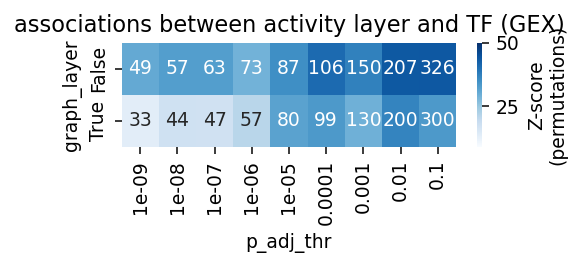

In [252]:
rcParams['figure.figsize'] = 4, 1
hm = table.pivot(index='graph_layer', columns='p_adj_thr', values='n_pos').fillna(0)
z = table.pivot(index='graph_layer', columns='p_adj_thr', values='zscore').fillna(0)
sns.heatmap(z, annot=hm, fmt='', cmap='Blues', cbar_kws={'label': 'Z-score\n(permutations)'},
            vmin=9,
            vmax=50)
plt.title('associations between activity layer and TF (GEX)')

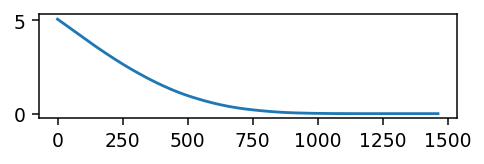

In [253]:
cumulative = np.cumsum(res.sort_values('p_adj')['p_adj']) / 100
plt.plot(range(len(cumulative)), cumulative[::-1])

In [254]:
shuffled[0].sort_values('p_val')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
6,12,False,106,Tubb2b,True,0.249618,7.320482e-43,IRF/2,1.383571e-40
182,267,True,48,Tspan14,True,-0.172110,6.451645e-21,NR/19,6.096805e-19
47,151,False,67,Arpc2,True,0.166080,1.444191e-19,SNAI2,9.098402e-18
3,9,False,71,Arl8a,True,-0.145520,2.457917e-15,TBX/2,1.161366e-13
19,42,False,49,Mgat4c,True,-0.139377,3.503820e-14,CREB/ATF/1,1.324444e-12
...,...,...,...,...,...,...,...,...,...
121,67,True,106,Traf2,True,0.003109,8.664064e-01,IRF/2,8.851395e-01
150,173,True,82,Tmem40,True,0.002054,9.115201e-01,POU/2,9.262220e-01
156,213,True,110,Ahr,True,-0.000753,9.674966e-01,ZIC/2,9.778442e-01
98,283,False,264,Art3,True,NaN,1.000000e+00,TFAP2/1,1.000000e+00


In [255]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
632,188,False,189,Nfix,True,0.319759,1.216309e-70,NFI/1,1.780676e-67
633,188,False,189,Nfib,True,0.250907,2.658609e-43,NFI/1,1.946102e-40
1275,127,True,128,Nfia,True,-0.230095,1.653331e-36,NFI/3,8.068255e-34
1363,188,True,189,Nfia,True,0.223500,1.721133e-34,NFI/1,6.299348e-32
1087,88,True,89,Sox4,True,0.218266,6.188602e-33,SOX/1,1.812023e-30
...,...,...,...,...,...,...,...,...,...
537,119,False,120,Lef1,True,-0.000922,9.602311e-01,LEF1,1.000000e+00
1293,150,True,151,Rest,True,NaN,1.000000e+00,REST/NRSF,1.000000e+00
526,112,False,113,Taf10,True,0.000483,9.791646e-01,GC-tract,1.000000e+00
1307,158,True,159,Reln,True,NaN,1.000000e+00,NFKB/3,1.000000e+00


In [256]:
from statsmodels.stats.multitest import fdrcorrection
res['p_adj'] = fdrcorrection(res['p_val'])[1]
# res[res['p_adj'] < 0.1]

In [257]:
genes_by_module_name = res.groupby(['module_name'])['gene_name'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
# genes_by_module_name

In [258]:
res[res['gene_name'] == 'Malat1']

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj


In [259]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj
632,188,False,189,Nfix,True,0.319759,1.216309e-70,NFI/1,1.780676e-67
633,188,False,189,Nfib,True,0.250907,2.658609e-43,NFI/1,1.946102e-40
1275,127,True,128,Nfia,True,-0.230095,1.653331e-36,NFI/3,8.068255e-34
1363,188,True,189,Nfia,True,0.223500,1.721133e-34,NFI/1,6.299348e-32
1087,88,True,89,Sox4,True,0.218266,6.188602e-33,SOX/1,1.812023e-30
...,...,...,...,...,...,...,...,...,...
537,119,False,120,Lef1,True,-0.000922,9.602311e-01,LEF1,1.000000e+00
1293,150,True,151,Rest,True,NaN,1.000000e+00,REST/NRSF,1.000000e+00
526,112,False,113,Taf10,True,0.000483,9.791646e-01,GC-tract,1.000000e+00
1307,158,True,159,Reln,True,NaN,1.000000e+00,NFKB/3,1.000000e+00


In [260]:
res['k'] = res['gene_name'] + '_' + res['archetype_id'].astype(str)
df2 = res.pivot(index='k', columns='opt_log_dynamic', values='spearman')
# df2 = res # .pivot(index='k', columns='opt_log_dynamic', values='spearman')

In [261]:
df2

opt_log_dynamic,False,True
k,,
Ahr_284,-0.020736,-0.008491
Ap2a1_264,0.048429,0.067617
Ap2a2_264,0.160128,0.076035
Ap2b1_264,0.196304,0.122003
Arid3a_24,-0.040370,-0.001627
...,...,...
Zic1_110,-0.075631,-0.082992
Zic1_273,-0.056101,-0.093769
Zic2_273,0.014570,-0.034862


In [262]:
mb.pl.set_rcParams({'figure.figsize': [5, 4], 'figure.dpi': 120})
# df2 = df2.sort_values('matched', ascending=True)
# plt.scatter(df2[True], df2[True],
#             color=np.where(df2['matched'], 'blue', 'gray'),
#             s=np.where(df2['matched'], 30, 5))
# plt.xlabel('TF activity (graph = off)')
# plt.ylabel('TF activity (graph = on)')
# plt.axhline(0, color='gray', ls='--', zorder=0)
# plt.axvline(0, color='gray', ls='--', zorder=0)


In [263]:
# df2[df2['matched'] == True].sort_values(True, ascending=False)

In [264]:
# res['arch_name'] = name_by_filter_id

In [265]:
res.sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
632,188,False,189,Nfix,True,0.319759,1.216309e-70,NFI/1,1.780676e-67,Nfix_189
633,188,False,189,Nfib,True,0.250907,2.658609e-43,NFI/1,1.946102e-40,Nfib_189
1275,127,True,128,Nfia,True,-0.230095,1.653331e-36,NFI/3,8.068255e-34,Nfia_128
1363,188,True,189,Nfia,True,0.223500,1.721133e-34,NFI/1,6.299348e-32,Nfia_189
1087,88,True,89,Sox4,True,0.218266,6.188602e-33,SOX/1,1.812023e-30,Sox4_89
...,...,...,...,...,...,...,...,...,...,...
537,119,False,120,Lef1,True,-0.000922,9.602311e-01,LEF1,1.000000e+00,Lef1_120
1293,150,True,151,Rest,True,NaN,1.000000e+00,REST/NRSF,1.000000e+00,Rest_151
526,112,False,113,Taf10,True,0.000483,9.791646e-01,GC-tract,1.000000e+00,Taf10_113
1307,158,True,159,Reln,True,NaN,1.000000e+00,NFKB/3,1.000000e+00,Reln_159


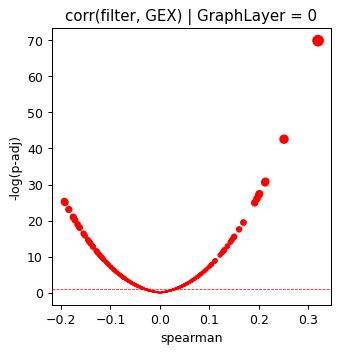

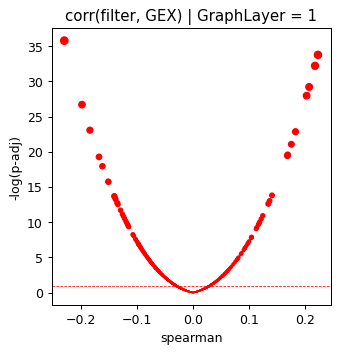

In [266]:
rcParams['figure.figsize'] = 4, 4
rcParams['figure.dpi'] = 90

for optimize_log_dynamic, grp in res.groupby('opt_log_dynamic'):
    grp['minus_log10_pval'] = -np.log10(grp['p_val'])
    grp = grp.sort_values('matched')
    plt.scatter(grp['spearman'], grp['minus_log10_pval'],
                s=np.power(grp['minus_log10_pval'], 1), color=np.where(grp['matched'], 'red', 'blue'))
    plt.ylabel('-log(p-adj)')
    plt.xlabel('spearman')
    plt.title('corr(filter, GEX) | GraphLayer = %i' % optimize_log_dynamic)
    plt.axhline(1, ls='--', color='red', lw=0.6)
    plt.show()

<Axes: xlabel='spearman', ylabel='Count'>

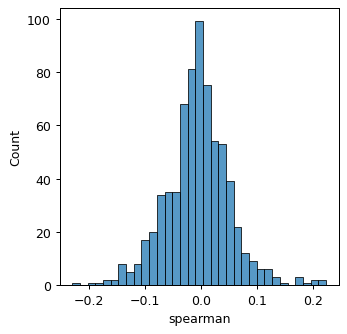

In [267]:
sns.histplot(grp['spearman'])

In [268]:
# sc.pl.umap(ad, color=[96], cmap='RdBu_r')
# sc.pl.umap(rna_sel, color=['Ehf', 'Ergic2'], cmap='plasma')

Text(0, 0.5, '# associations')

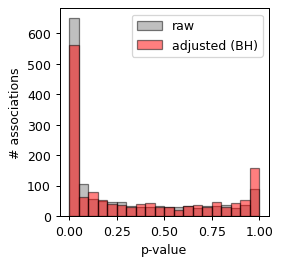

In [269]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 90
plt.hist(res['p_val'], color='gray', bins=20, label='raw', alpha=.5, edgecolor = 'black')
plt.hist(res['p_adj'], color='red', bins=20, label='adjusted (BH)', alpha=.5, edgecolor = 'black')
plt.xlabel('p-value')
plt.legend()
plt.ylabel('# associations')

In [270]:
res[res['p_adj'] < 0.05]

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
2,1,False,2,Arxes2,True,-0.070837,1.242692e-04,HD/2,6.713289e-04,Arxes2_2
4,1,False,2,Dlx1,True,-0.044999,1.485109e-02,HD/2,4.004051e-02,Dlx1_2
5,1,False,2,Dlx2,True,-0.127555,4.213276e-12,HD/2,8.939473e-11,Dlx2_2
6,1,False,2,Lhx6,True,-0.109959,2.407531e-09,HD/2,3.325119e-08,Lhx6_2
10,1,False,2,Pou6f1,True,-0.047802,9.656791e-03,HD/2,2.844576e-02,Pou6f1_2
...,...,...,...,...,...,...,...,...,...,...
1448,263,True,264,Ap2a1,True,0.067617,2.495745e-04,TFAP2/1,1.273091e-03,Ap2a1_264
1449,263,True,264,Ap2a2,True,0.076035,3.789218e-05,TFAP2/1,2.433077e-04,Ap2a2_264
1452,272,True,273,Zic3,True,-0.044315,1.644439e-02,ZIC,4.361337e-02,Zic3_273
1455,272,True,273,Zic1,True,-0.093769,3.682010e-07,ZIC,3.642204e-06,Zic1_273


In [271]:
pval_thr = 1e-5
sel_genes = set(list(res[res['p_adj'] < pval_thr]['gene_name']))

In [272]:
log_act = ad.obsm['log_activities'].copy()

In [273]:
cols_act = ['intercept', 'dinuc_bias'] + [name_by_filter_id[k] for k in log_act.columns[2:]]
log_act.columns = cols_act

In [274]:
import anndata
ad_act = anndata.AnnData(log_act)
ad_act.obsm['X_umap'] = ad.obsm['X_umap']
ad_act.obs = ad.obs

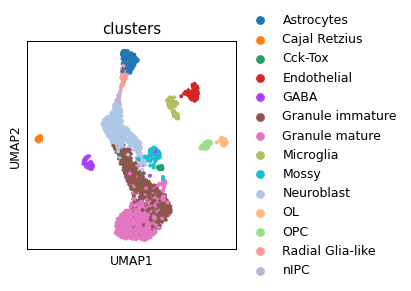

In [275]:
sc.pl.umap(ad_act, color=cell_type_key)


Rank genes groups using the annotation

In [276]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)
rkg_df = []
for ct in ad_act.obs[cell_type_key].values.unique():
    print(ct)
    rkg_df2 = sc.get.rank_genes_groups_df(ad_act, ct)
    rkg_df2[cell_type_key] = ct
    rkg_df.append(rkg_df2)
rkg_df = pd.concat(rkg_df)
rkg_df['module_name'] = rkg_df['names'].map(anno.set_index('Cluster_ID')['Name'].to_dict())
rkg_df['module_name'] = np.where(~pd.isnull(rkg_df['module_name']), rkg_df['module_name'], rkg_df['names'])
rkg_df.head()

Granule immature
Radial Glia-like
Granule mature
Neuroblast
Microglia
Cajal Retzius
OPC
Cck-Tox
GABA
Endothelial
Astrocytes
OL
Mossy
nIPC


,names,scores,logfoldchanges,pvals,pvals_adj,clusters,module_name
0,AHR,18.531593,NaN,2.691616e-69,7.751853e-67,Granule immature,AHR
1,NFAC/2,17.855738,NaN,2.289548e-65,3.296949e-63,Granule immature,NFAC/2
2,TFAP2/1,16.599554,NaN,2.289675e-57,2.198088e-55,Granule immature,TFAP2/1
3,TBX/2,16.345110,NaN,7.831930e-56,5.638990e-54,Granule immature,TBX/2
4,HD/3,16.175728,NaN,4.929512e-55,2.839399e-53,Granule immature,HD/3


Get top modules

In [277]:
ad_act.var_names = ad_act.var_names.map(rkg_df.set_index('names')['module_name'].to_dict())

In [278]:
sc.tl.rank_genes_groups(ad_act, cell_type_key)

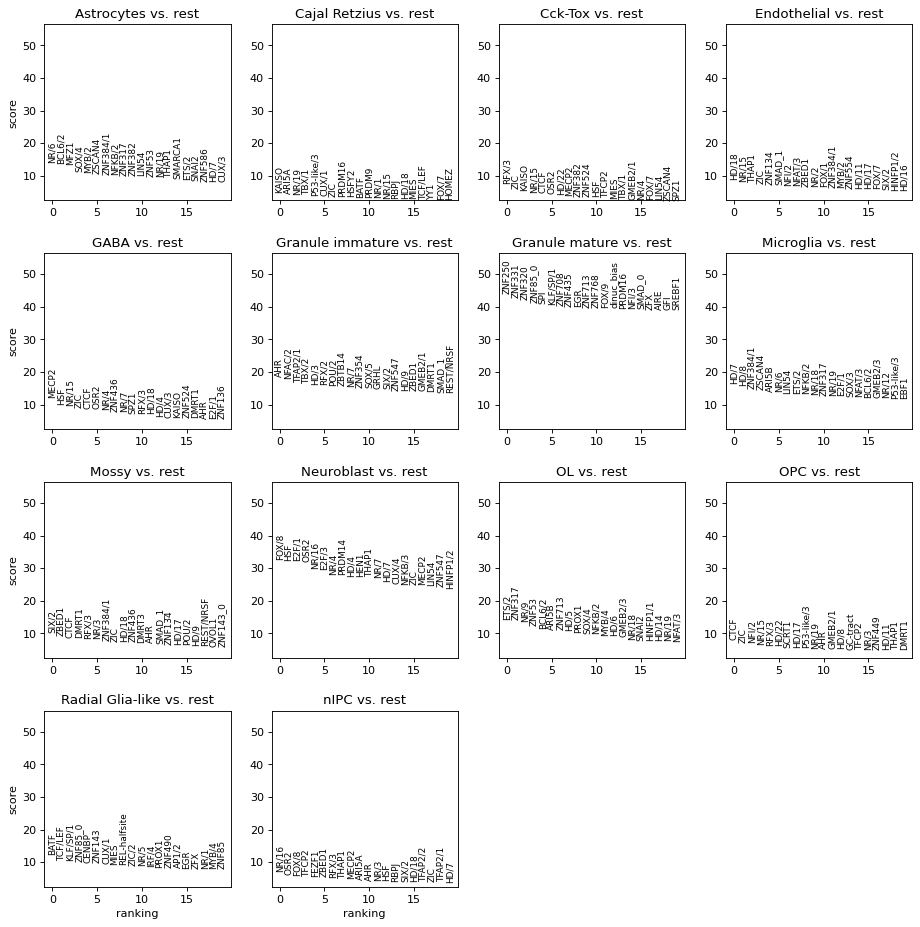

In [279]:
rcParams['figure.figsize'] = 3.5, 3.5
rcParams['figure.dpi'] = 80
sc.pl.rank_genes_groups(ad_act)


In [280]:
set(res[(res['p_adj'] < 1e-5)]['k'])

{'Ap2a2_264',
 'Ap2b1_264',
 'Arnt2_58',
 'Arnt2_60',
 'Arx_2',
 'Arx_8',
 'Arxes1_8',
 'Atf3_54',
 'Atf4_51',
 'Bach2_53',
 'Bhlhe22_62',
 'Cebpb_52',
 'Creb3_61',
 'Cux1_15',
 'Dlx2_2',
 'Dlx5_2',
 'Ebf1_174',
 'Egr1_109',
 'Elk1_98',
 'Epas1_60',
 'Erg_96',
 'Ergic1_96',
 'Ergic1_98',
 'Ergic2_96',
 'Ergic2_98',
 'Ets1_96',
 'Ets1_98',
 'Etv4_98',
 'Etv5_96',
 'Fli1_96',
 'Fos_49',
 'Fos_54',
 'Fosb_54',
 'Foxf2_80',
 'Foxj3_80',
 'Foxk2_79',
 'Foxo1_80',
 'Foxq1_80',
 'Hes1_59',
 'Hes5_58',
 'Hlf_52',
 'Id2_58',
 'Id4_68',
 'Irf2bp2_106',
 'Irf2bpl_106',
 'Jun_50',
 'Jund_50',
 'Klf11_112',
 'Klf13_109',
 'Klf4_109',
 'Klf4_112',
 'Klf6_109',
 'Klf9_112',
 'Lhx6_2',
 'Lyl1_63',
 'Maf_53',
 'Maf_55',
 'Mafb_53',
 'Mafb_55',
 'Mafk_55',
 'Maz_113',
 'Mecp2_97',
 'Mgat1_71',
 'Mgat3_71',
 'Mgat3_73',
 'Mgat4b_71',
 'Mgat4b_73',
 'Mgat4c_71',
 'Mgat4c_73',
 'Mgat5b_71',
 'Mgat5b_73',
 'Mycbp_59',
 'Mycl_59',
 'Mycn_59',
 'Neurod2_62',
 'Nfe2l1_54',
 'Nfe2l2_53',
 'Nfe2l2_54',
 'Nfia_12

In [281]:
res[res['module_name'].str.contains('HD')].sort_values('p_adj')

,filter_id,opt_log_dynamic,archetype_id,gene_name,matched,spearman,p_val,module_name,p_adj,k
746,1,True,2,Nkx6-2,True,-0.140372,2.296180e-14,HD/2,6.935310e-13,Nkx6-2_2
781,20,True,21,Pbx1,True,-0.129497,1.974612e-12,HD/16,4.516925e-11,Pbx1_21
5,1,False,2,Dlx2,True,-0.127555,4.213276e-12,HD/2,8.939473e-11,Dlx2_2
33,7,False,8,Arx,True,0.125466,9.395638e-12,HD/8,1.884276e-10,Arx_8
12,1,False,2,Arx,True,-0.120439,6.137214e-11,HD/2,1.082516e-09,Arx_2
...,...,...,...,...,...,...,...,...,...,...
25,4,False,5,Msx1,True,NaN,1.000000e+00,HD/5,1.000000e+00,Msx1_5
17,1,False,2,Sp7,True,0.000882,9.619532e-01,HD/2,1.000000e+00,Sp7_2
784,23,True,24,Arid3a,True,-0.001627,9.298410e-01,HD/18,1.000000e+00,Arid3a_24
3,1,False,2,Msx1,True,NaN,1.000000e+00,HD/2,1.000000e+00,Msx1_2


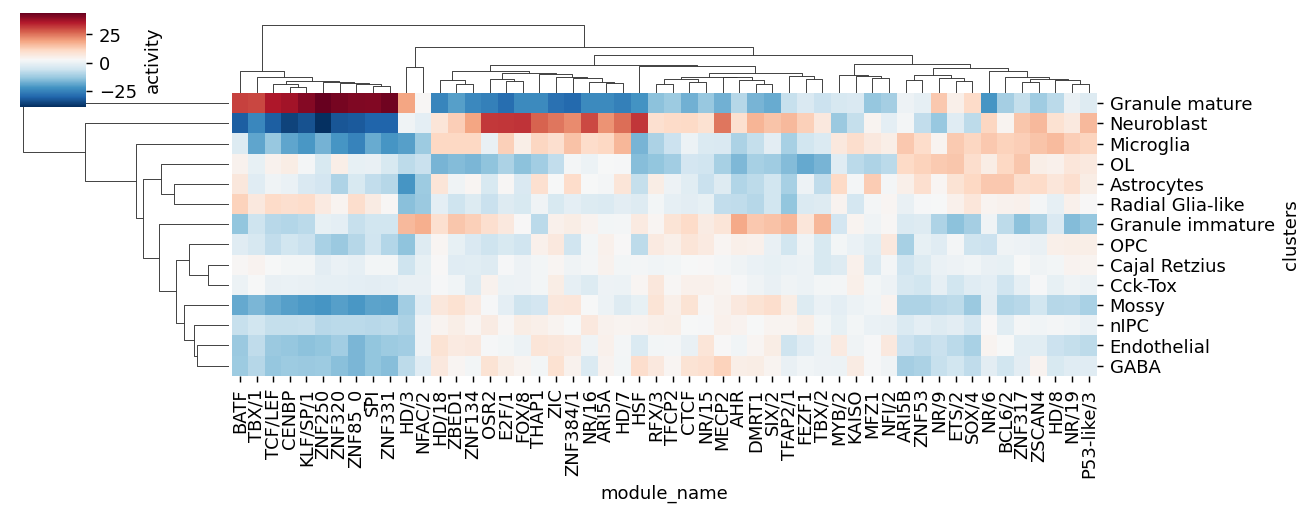

In [282]:
mod_names_best = set(rkg_df.sort_values('scores', ascending=False).groupby(cell_type_key).head(5)['module_name'])
best = rkg_df[rkg_df['module_name'].isin(mod_names_best)]
rcParams['figure.dpi'] = 130
sns.clustermap(best.pivot(index=cell_type_key, columns='module_name', values='scores'),
               cbar_kws={'label': 'activity'}, cmap='RdBu_r',
               # vmin=-5, vmax=5,
               figsize=[10.2, 4],
               # dpi=100,
               xticklabels=True)


In [283]:
rna_tfs = rna_sel.to_df()[list(set(res['gene_name']))]
rna_tfs[cell_type_key] = rna_sel.obs[cell_type_key]
mean_tfs = rna_tfs.groupby(cell_type_key).mean()

act_tfs_df = ad_act.to_df()
act_tfs_df[cell_type_key] = ad_act.obs[cell_type_key]
mean_act_tf = act_tfs_df.groupby(cell_type_key).mean()

In [284]:
corr_celltype = []
for i, c1 in enumerate(mean_act_tf):
    if i % 50 == 0:
        print(i, mean_act_tf.shape[1])
    for j, c2 in enumerate(mean_tfs):
        if not c1 in genes_by_module_name or not c2 in genes_by_module_name[c1]:
            continue
        a = mean_act_tf[c1]
        b = mean_tfs[c2]
        corr_celltype.append([c1, c2, mean_act_tf.index[np.argmax(mean_act_tf[c1])]] + list(pearsonr(a, b)))

corr = pd.DataFrame(corr_celltype,
                    columns=['module_name', 'gene_name', 'cell_type', 'pearsonr', 'p_val'])
corr = corr.sort_values('pearsonr', ascending=False)


0 288
50 288
100 288
150 288
200 288
250 288


In [285]:
# sc.pl.dotplot(rna_sel, groupby='celltype', var_names=list(set(res['gene_name'])))

In [286]:
corr[corr['pearsonr'] > 0].sort_values('p_val')

,module_name,gene_name,cell_type,pearsonr,p_val
90,NFKB/2,Nfkb1,Microglia,0.720772,0.003632
241,IRF/1,Irf2bp1,Granule immature,0.684378,0.006937
186,PRDM5,Prdm5,Granule mature,0.665715,0.009355
353,Ebox/CACGTG/2,Mycbp2,Granule mature,0.622733,0.017374
427,ETS/1,Elk1,Granule immature,0.609865,0.020571
...,...,...,...,...,...
258,TBX/4,Mgat4c,Granule mature,0.004274,0.988431
136,TBX/2,Mgat1,Granule immature,0.003873,0.989517
440,E2F/2,E2f4,Granule mature,0.003450,0.990661
122,HIC/1,Hic2,Neuroblast,0.002782,0.992470


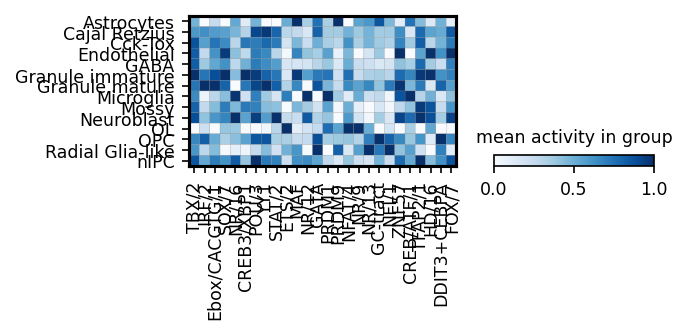

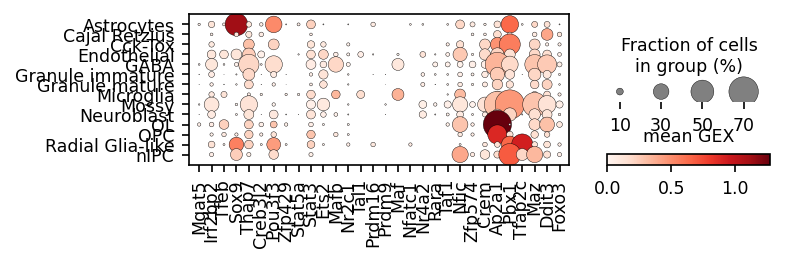

In [287]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 150
# repressors
module_names = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] < 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])
# activators

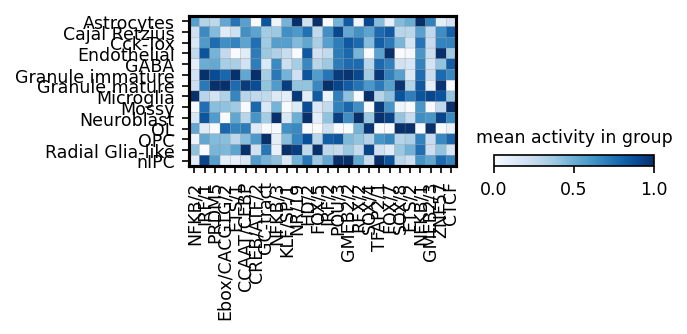

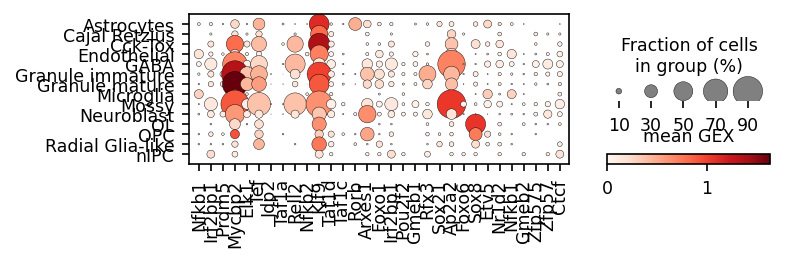

In [288]:

module_names = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['module_name'].drop_duplicates()
gene_names   = corr[corr['pearsonr'] > 0].sort_values('p_val').sort_values('p_val').groupby('cell_type').head(3)['gene_name']
sc.pl.matrixplot(ad_act,
            groupby=cell_type_key,
            cmap='Blues',
            var_names=module_names,
            figsize=[4, 1.3],
            standard_scale='var',
            colorbar_title='mean activity in group')
sc.pl.dotplot(rna_sel,
              groupby=cell_type_key,
              colorbar_title='mean GEX',
              var_names=gene_names,
              figsize=[5, 1.3])



## Filter activities versus graph activities

In [289]:
A = model.get_log_activities()
sum_A = A.abs().sum(axis=1).cpu().detach().numpy()
A = A.squeeze(0)
print(A.shape)

torch.Size([288, 2930])


In [290]:
# this function assesses the contributions of A on the graph
indices, contributions, max_eig = mb.tl.compute_contributions(A, C * D)

contributions_normalized = torch.abs(contributions) / max_eig
contributions_df = pd.DataFrame(contributions_normalized.detach(), columns=['index'])
print("Summary statistics of the normalized contributions: \n")
contributions_df.describe()

Summary statistics of the normalized contributions: 



,index
count,288.000000
mean,0.260369
std,0.075520
min,0.118971
25%,0.202913
50%,0.260636
75%,0.328480
max,0.421260


In [291]:
contributions.shape

torch.Size([288])

Percentage of non-zero entries of the filter matrix A: 100.0 %
(288,) (288,)


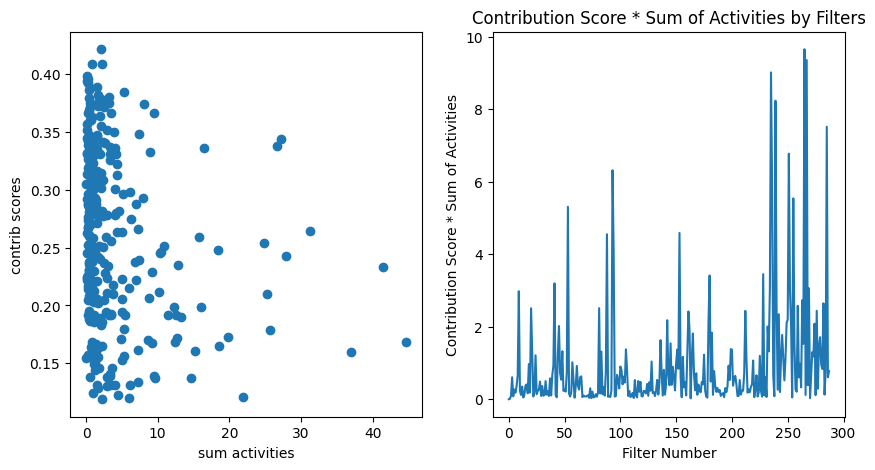

In [292]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 100
plt.figure(figsize=(10, 5))

print(f"Percentage of non-zero entries of the filter matrix A: {100 * torch.sum(A != 0).item() / A.numel()} %")
mb.pl.filter_contrib_simple(contributions_normalized, A.cpu())

In [293]:
# normalize the data, and look at summary stats
sum_A_norm = sum_A / np.max(sum_A)
sum_A_df = pd.DataFrame(sum_A.T, columns=['sum_A'])
sum_A_df.describe()

,sum_A
count,2930.000000
mean,0.389976
std,0.267251
min,0.049273
25%,0.208560
50%,0.317015
75%,0.490032
max,2.646478


In [294]:
contrib_arr = contributions_normalized.unsqueeze(dim=0).detach().numpy()
sum_A = A.cpu().abs().sum(axis=1).detach().numpy()
contrib = contrib_arr[0]

contrib_times_activities = contrib * sum_A
contrib_times_activities_norm = contrib_times_activities / np.max(contrib_times_activities)
contrib_times_activities_df = pd.DataFrame(contrib_times_activities, columns=['contribution_times_activities'])
contrib_times_activities_df.describe()

,contribution_times_activities
count,288.000000
mean,0.923566
std,1.503020
min,0.000033
25%,0.138748
50%,0.380360
75%,1.009978
max,9.655407


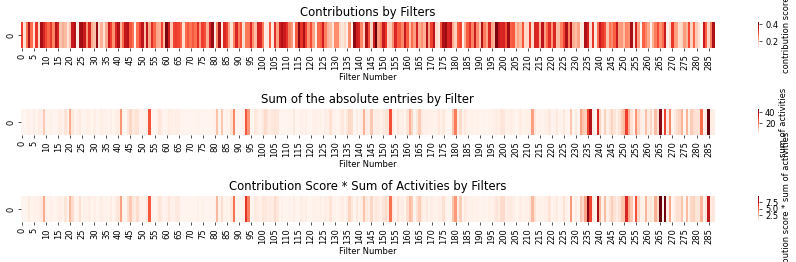

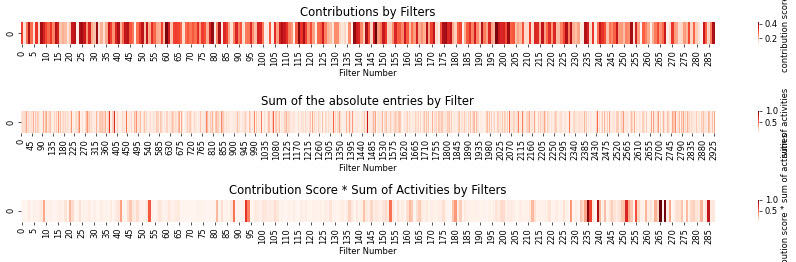

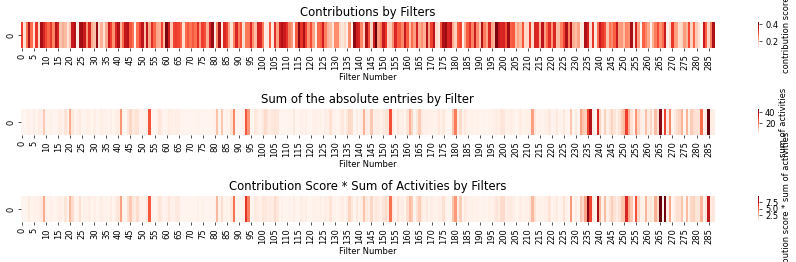

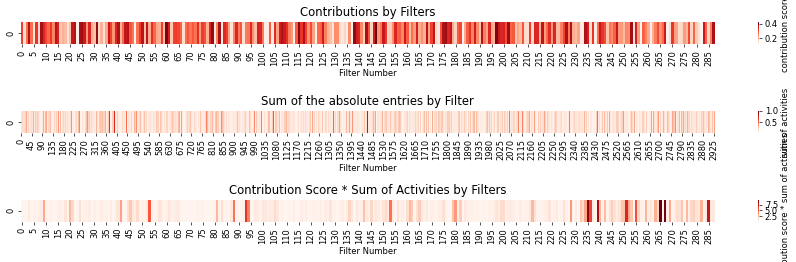

In [295]:
from matplotlib.pyplot import rcParams
rcParams['figure.dpi'] = 60

# unsqueeze the data to make it compatible with the heatmap function
sum_A_norm = sum_A_norm.reshape(1,-1)
contrib_times_activities = contrib_times_activities.reshape(1,-1)


# only plotting filters, that are within the top 25% of the maximum contribution score
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')
                       # (0.66, 11.85, 6.49),
                       # (0.66, 11.85, 6.49)) # vmin values come from the describe() functions

# plotting top 25% of filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities_norm.reshape(1,-1),
                       cmap='Reds')
                       # vmins=(0.66, 0.14, 0.19),
                       # centers=(0.66, 0.14, 0.19)) # vmin values come from the describe() functions

# plotting all filter
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A.reshape(1, -1),
                       contrib_times_activities,
                       cmap='Reds')

# plotting all filters normalized
mb.pl.contrib_heatmaps(contributions_normalized,
                       sum_A_norm,
                       contrib_times_activities,
                       cmap='Reds')

TFAP2/1:Ap2b1 (0.13927497174520487, 0.19630439839437236) 0.07348056137561798
TFAP2/1:Ap2a2 (0.11360855324892978, 0.1601282586420917) 0.07348056137561798
CCAAT/CEBP:Hlf (0.0994192774309763, -0.14084963382544488) 0.1330038160085678
TFAP2/1:Ap2b1 (0.0865592551290149, 0.12200298654270796) 0.07348056137561798
CCAAT/CEBP:Tef (0.07583289629155376, -0.10743425169232189) 0.1330038160085678
CCAAT/CEBP:Cebpb (0.0656770674562221, -0.09304624959038071) 0.1330038160085678
CCAAT/CEBP:Dbpht2 (0.05935114351238866, 0.08408416402588695) 0.1330038160085678
PROX1:Prox1 (0.055070467249913345, -0.07670010295941576) 0.08719600737094879
TFAP2/1:Ap2a2 (0.05394601923419597, 0.07603549093453456) 0.07348056137561798
TFAP2/1:Tfap2c (0.05273286695570415, -0.07432558480275823) 0.07348056137561798


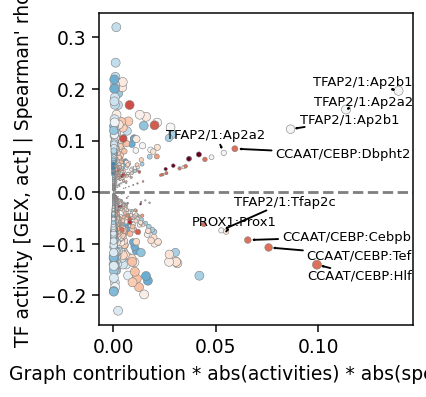

In [296]:
rcParams['figure.figsize'] = 3, 3
rcParams['figure.dpi'] = 135
from adjustText import adjust_text

def delta_models(model_by_logdynamic):
    model = model_by_logdynamic[True]
    log_act1 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act1 = pd.DataFrame(log_act1.detach().cpu().numpy())

    model = model_by_logdynamic[False]
    log_act2 = torch.stack(list(model.activities.log_activities), dim=1).squeeze(0).T
    log_act2 = pd.DataFrame(log_act2.detach().cpu().numpy())

    d = log_act1.mean(axis=0) - log_act2.mean(axis=0)
    # d.index = ad.obs_names
    return d

# graph = True - graph = False
delta_model = delta_models(model_by_logdynamic)
delta_model
delta_model = delta_model[2:]
delta_model.index = range(len(delta_model))
delta_model.index += 1
delta_model.index = delta_model.index.map(name_by_filter_id)
delta_model

res['act_change'] = res['module_name'].map(delta_model.to_dict())
res['k'] = res['module_name'] + ':' + res['gene_name']
res['graph_score'] = res['filter_id'].map({i : contrib_times_activities[0][i + 2] for i in range(len(contrib_times_activities[0]) - 2)})
res['z'] = np.sqrt((res['graph_score'] ** 2) * (-np.log(res['p_adj'] + 1e-10)) ** 2)


ax = plt.subplot()
cmap = sns.color_palette('RdBu_r', as_cmap=True)

res_sel = res.sort_values('z', ascending=False)
res_sel = res_sel.sort_values('z', ascending=False) # .drop_duplicates('module_name')
# res_sel = res_sel.drop_duplicates('module_name')

# res_sel['x'] = np.log((res_sel['graph_score'] + 1) * (res_sel['act_change'].abs() + 1))
res_sel['x'] = res_sel['graph_score'] * res_sel['act_change'].abs() * res_sel['spearman'].abs()
plt.scatter(res_sel['x'],            
            res_sel['spearman'],
            s=-np.log(res_sel['p_adj'] + 1e-10),
            cmap=cmap,
            lw=.3,
            edgecolors='gray',
            c=res_sel['act_change'])
plt.axhline(y=0, ls='--', c='gray')
plt.xlabel('Graph contribution * abs(activities) * abs(spearman)')
plt.ylabel('TF activity [GEX, act] | Spearman\' rho')


res_sel = res_sel.sort_values('x', ascending=False) # .drop_duplicates('module_name')
texts = [] # [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]

for ri, r in res_sel.head(10).iterrows():
    print(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), r['act_change'])
    t = ax.annotate(r['module_name'] + ':' + r['gene_name'], (r['x'], r['spearman']), fontsize=7)
    texts.append(t)
adjust_text(texts, arrowprops=dict(arrowstyle='->'))

In [297]:
def running_mean(y_in, x_in, N_out=101, sigma=.05):
    '''
    Returns running mean as a Bell-curve weighted average at evenly spaced
    points. Does NOT wrap signal around, or pad with zeros.
    
    Arguments:
    y_in -- y values, the values to be smoothed and re-sampled
    x_in -- x values for array
    
    Keyword arguments:
    N_out -- NoOf elements in resampled array.
    sigma -- 'Width' of Bell-curve in units of param x .
    '''
    import numpy as np
    N_in = len(y_in)

    # Gaussian kernel
    x_out = np.linspace(np.min(x_in), np.max(x_in), N_out)
    x_in_mesh, x_out_mesh = np.meshgrid(x_in, x_out)
    gauss_kernel = np.exp(-np.square(x_in_mesh - x_out_mesh) / (2 * sigma**2))
    # Normalize kernel, such that the sum is one along axis 1
    normalization = np.tile(np.reshape(np.sum(gauss_kernel, axis=1), (N_out, 1)), (1, N_in))
    gauss_kernel_normalized = gauss_kernel / normalization
    # Perform running average as a linear operation
    y_out = gauss_kernel_normalized @ y_in

    return y_out, x_out

def plot_pseudotime(rna, gene_name, filter_name, sigma_gex=.05, sigma_filter=.1):
    rcParams['figure.figsize'] = 3, 2
    gene_key = gene_name
    x = rna.obs['velocity_pseudotime']
    y = rna[:,rna.var_names==gene_key].X.A.flatten()
    y = np.log(y)
    y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_gex)
    plt.scatter(x, y, edgecolors=None, color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='green')
    plt.ylabel('')
    plt.title(gene_key)
    plt.ylabel('gene expression [log]')
    plt.xlabel('pseudotime')


    x = ad.obs['velocity_pseudotime']

    plt.show()
    filter_id = int(res[res['module_name'].str.contains(filter_name)]['filter_id'].values[0])

    y= act.T.numpy()[:,filter_id]
    # y = np.abs(y)
    # y = np.log(y)
    # y[y == -np.inf] = np.nanmin(y[y != -np.inf])

    y_mean, x_mean = running_mean(y, x, sigma=sigma_filter)
    # plt.scatter(x, y, edgecolors='black', color='lightgreen', s=.1)
    plt.plot(x_mean, y_mean, color='blue')
    plt.ylabel('')
    plt.title('filter activities %s' % filter_name)
    plt.ylabel('filter activity')
    plt.xlabel('pseudotime')


In [298]:
scv.tl.velocity_pseudotime(rna_sample)

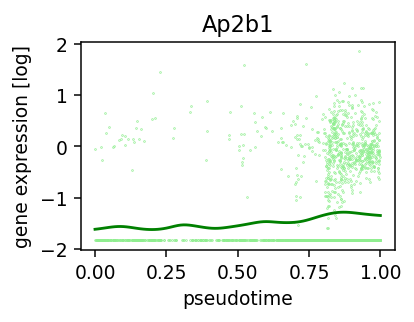

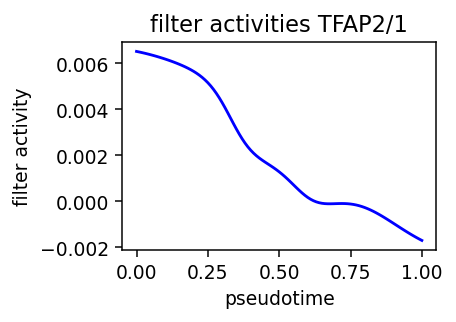

In [299]:
plot_pseudotime(rna_sample, 'Ap2b1', 'TFAP2/1', sigma_gex=.05, sigma_filter=.1)

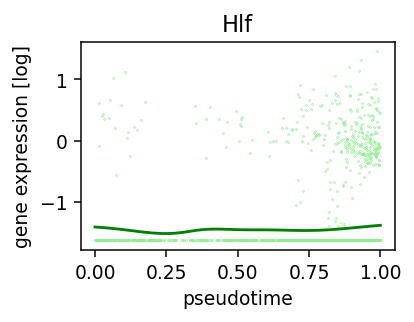

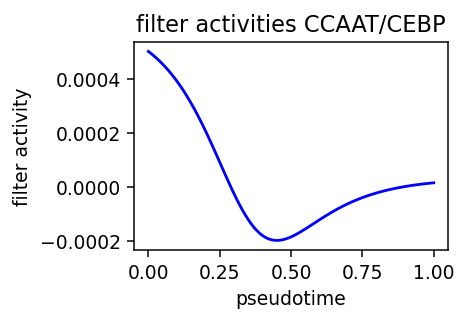

In [300]:
plot_pseudotime(rna_sample, 'Hlf', 'CCAAT/CEBP', sigma_gex=.1, sigma_filter=.2)